In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
            os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.init = nn.Sequential(
            nn.Conv2d(3*2, 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.LeakyReLU(0.2)
        )
        self.model = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect"),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect") ,
            nn.Sigmoid()
        )
    
    def forward(self, x, y):
        x = torch.cat([x,y], dim = 1)
        x = self.init(x)
        return self.model(x)

In [62]:
class loss_f_d(nn.Module):
    def __init__(self):
        super(loss_f_d, self).__init__()
        self.lmbda = 0.5
    
    def forward(self, gen_prob, y_prob, gen, y):
        loss_y = -torch.log(y_prob + 1e-10).mean()
        loss_gen = -torch.log(1 - gen_prob + 1e-10).mean()
        reg = torch.abs(y - gen).mean()
        return loss_y + loss_gen + self.lmbda*reg

class loss_f_g(nn.Module):
    def __init__(self):
        super(loss_f_g, self).__init__()
        self.lmbda = 0.5
        
    def forward(self, gen_prob, gen, y):
        reg = torch.abs(y - gen).mean()
        return -torch.log(gen_prob + 1e-10).mean() + self.lmbda*reg

In [63]:
device = torch.device("cpu")
device

device(type='cpu')

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [65]:
bce = nn.BCELoss().to(device)
l1 = nn.L1Loss().to(device)

In [66]:
import torch.optim as optim
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

generator = Generator().to(device)
dminator = Discriminator().to(device)

data_path = "/kaggle/input/private-1/archive-3/Train/Raw"

opt_gen = optim.Adam(generator.parameters(), lr=1e-3, betas = (0.5, 0.999))
opt_dis = optim.Adam(dminator.parameters(), lr=1e-3, betas = (0.5, 0.999))

# loss_g = loss_f_g().to(device)
# loss_d = loss_f_d().to(device)


class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        try:
            input_image = plt.imread(image_path)
            target_image = plt.imread(image_path.replace("Raw", "Reference"))
        except Exception as e:
            return torch.zeros(1,1)
            
        input_image = self.transform(input_image)
        target_image = self.transform(target_image)
        return input_image, target_image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=1, shuffle=True)

#training loop
epochs = 10
gen_loss = 0
dis_loss = 0
LAMBDA = 1

# for x in X:
#     print(x)
#     break

for epoch in range(epochs):
    for data in X:
        if len(data) == 1:
            continue
        input_image, target_image = data
        input_image = input_image.to(device)
        target_image = target_image.to(device)
        
        # Training generator
        opt_gen.zero_grad()
        gen_img = generator(input_image)
        fake_prob = dminator(input_image, gen_img)
        gen_loss = bce(fake_prob, torch.ones_like(fake_prob)) + l1(gen_img, target_image)
        gen_loss.backward()
        opt_gen.step()
        
        # Training discriminator
        opt_dis.zero_grad()
        real_prob = dminator(input_image, target_image)
        fake_prob = dminator(input_image, gen_img.detach())
        dis_loss = bce(real_prob, torch.ones_like(real_prob)) + bce(fake_prob, torch.zeros_like(fake_prob))
        dis_loss.backward()
        opt_dis.step()
        

    print(f"Epoch {epoch+1}/10")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [67]:
torch.save(generator.state_dict(), "gen2.pth")
gen_model = Generator().to(device)
gen_model.load_state_dict(torch.load("gen2.pth"))
gen_model.eval()

/tmp/ipykernel_31/2544609948.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load("gen2.pth"))


Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

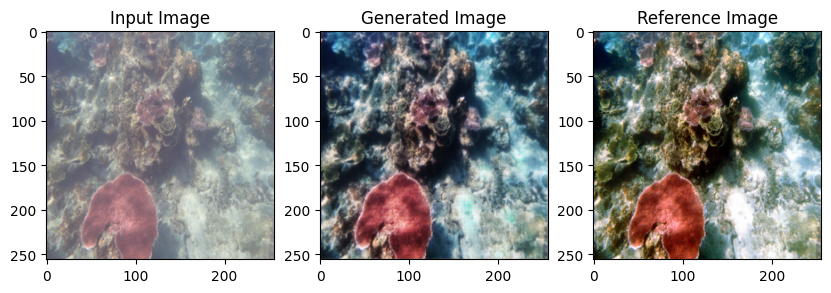

In [82]:
input_image_path = "/kaggle/input/private-1/archive-3/Train/Raw/123_img_.png"
reference_path = "/kaggle/input/private-1/archive-3/Train/Reference/123_img_.png"

img = plt.imread(input_image_path)
input_img = transform(img)
input_img = input_img.unsqueeze(0).to(device)  # Add batch dimension

gen_img = generator(input_img)
gen_img = gen_img.squeeze(0).detach().cpu().numpy()  # Remove batch dimension

ref_img = plt.imread(reference_path)
ref_img = transform(ref_img).detach().cpu().numpy()  # Convert to numpy for consistency

# Both gen_img and ref_img are in [-1, 1], so we need to scale them back to [0, 1]
gen_img = (gen_img + 1) / 2  # Convert to range [0, 1]
ref_img = (ref_img + 1) / 2  # Convert to range [0, 1]
input_img = input_img.squeeze(0).detach().cpu().numpy()
input_img = (input_img + 1) / 2

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.transpose(input_img, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(np.transpose(gen_img, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
plt.title('Generated Image')

plt.subplot(1, 3, 3)
plt.imshow(np.transpose(ref_img, (1, 2, 0)))
plt.title('Reference Image')

plt.show()

In [ ]:
from scikitlearn.metrics import structural_similarity as ssim

def ssim_on_test(model):

    test_path = "/kaggle/input/private-1/archive-3/Test/"
    
    model.eval()

    ssim_scores = []

    class ImageDataset(Dataset):
        def __init__(self,path, transformer):
            self.path = path
            self.image_files = os.listdir(self.path)
            self.transform = transformer
        
        def __len__(self): 
            return len(os.listdir(self.path)) 
        
        def __getitem__(self, index):
            image_name = self.image_files[index]
            image_path = os.path.join(self.path, image_name)
            try:
                input_image = plt.imread(image_path)
                target_image = plt.imread(image_path.replace("Raw", "Reference"))
            except Exception as e:
                return torch.zeros(1,1)
                
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
            return input_image, target_image
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    
    dataset = ImageDataset(test_path, transform)
    X_test = DataLoader(dataset, batch_size=1, shuffle=False)


    for data in X_test:
        if len(data) <= 1:
            continue

        raw_image, ref_image = data
        
        raw_image = raw_image.unsqueeze(0).to(device)
        
        ref_img = transform(ref_img).detach().cpu().numpy()
        ref_img = (ref_img + 1) / 2
        
        gen_image = model(raw_image)
        gen_img = gen_img.squeeze(0).detach().cpu().numpy()
        
        ssim_score, _ = ssim(gen_image, ref_image, full=True)
        ssim_scores.append(ssim_score)
    
    overall_ssim = np.mean(ssim_scores)
    print(f'Overall SSIM score: {overall_ssim}')

ssim_on_test(generator)